In [160]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import hdbscan
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import warnings
warnings.simplefilter(action='ignore')

In [2]:
path = "../../datas/"
naver = pd.read_csv(path+"v5_category_re_token_sum.csv")
kakao = pd.read_csv(path+"kakao_review_cat_predict_token_sum.csv")

n_reviews = naver[['title', 'highlight_review', 'category', 'user_name', 'star']].copy()
n_reviews.rename(columns={'title': 'camp', "highlight_review": 'review', "user_name": "username"}, inplace=True)
n_reviews['platform'] = 'NAVER'
k_reviews = kakao[['place_name', 'contents', 'category', 'username', 'point']].copy()
k_reviews.dropna(axis=0, inplace=True)
k_reviews.rename(columns={'place_name': 'camp', "contents": 'review', 'point': 'star'}, inplace=True)
k_reviews['platform'] = 'KAKAO'

data = pd.concat([n_reviews, k_reviews], axis=0).reset_index()[['camp', 'review', 'category', 'star', 'username', 'platform']]

In [3]:
data

,camp,review,category,star,username,platform
0,진달래 관광농원 캠핑장,데크가 너무 작다,메인시설,3.0,qkrgmldms582,NAVER
1,진달래 관광농원 캠핑장,따뜻하다물 자다 나오다,메인시설,4.0,cho****,NAVER
2,진달래 관광농원 캠핑장,데크도 작고,메인시설,1.5,jin****,NAVER
3,진달래 관광농원 캠핑장,방이 상당하다 깨끗하다 좋다,메인시설,5.0,Ringo,NAVER
4,진달래 관광농원 캠핑장,데크가 조금 작다,메인시설,4.5,아메리깐,NAVER
...,...,...,...,...,...,...
124267,양양오색 휴랜드 야영장,생기다얼마안되다 깨끗하다\n시에서 운영하다 아니다 사만원이나 받다 매점은 없다 온수...,메인시설,2.0,girl,KAKAO
124268,귀촌 관광농원,카페 위치랑 쉬다딱좋다곳..\n테이블 의자셋팅 풍경 너무좋다..\n하지만 커피맛은 ...,메인시설,3.0,배현환,KAKAO
124269,귀촌 관광농원,2층 테라스도 있다 주차장 넓다 좋다 정원도 있다 아이들도 놀다 좋다~,부대/공용시설,5.0,심석연(바라봄의법칙),KAKAO
124270,귀촌 관광농원,넓다 한적하다 정원 예쁘다 테라스까지 넘다 좋다^^ \n,부대/공용시설,5.0,로지,KAKAO


In [6]:
camp_df = pd.pivot_table(data, index='camp', values=['star', 'review'],
               aggfunc={'star': 'mean', 'review': 'count'}).reset_index()

camp_list = np.unique(camp_df['camp']).tolist()
review_list = []
for cp in camp_list:
    rv_list = data[data['camp']==cp]['review'].tolist()
    rv_set = ''
    for rv in rv_list:
        rv_set += ' '+str(rv)
        rv_set =  re.sub(r"[^가-힣A-Za-z0-9!?'']", " ", rv_set)
    review_list.append(rv_set)
camp_df['review_set'] = review_list

,camp,review,star,review_set
0,(주)데일리랜드,236,4.489407,소음이심하다 샤워실과 개수대에 온수도안나오다 산속 넓다 사이트 깨끗하다 관리가 잘...
1,(주)밀모 빨강치마 야영장,6,4.500000,최고이다 담달 또오다 물가계곡 너무 좋다 여기처럼 물놀이하고 쉬다 힐링하다...
2,(주)쉐르빌리안티티,3,4.666667,길쪽에 담배냄새 때문에 힘들다 차다 담배피면 담배냄새오다알다 굳이거기서피다 친절하...
3,(주)아웃오브파크,8,4.187500,사장님 모두 엄청 친절하다 최고이다 바베큐 그릴도 좋다습 니다 분위기좋다 너무 좋...
4,(주)어반슬로우시티,325,4.680000,화장실도 침구도 너무 깨끗하다 좋다 시설이 너무 깔끔하다 깨끗하다 시설 깔끔하다...
...,...,...,...,...
1316,힐링가평오토캠핑장,2,5.000000,2박하다 편하다좋다 사장님이 아주친절하다 좋다 사장님 친절하다 임진강 경치가 한눈...
1317,힐링아일랜드 글램핑,1,4.000000,열두시가 넘다 웃다 떠들다대다 크다목소리의 건너편 텐트만 아니다 좋다편입니다 단...
1318,힐링캠프글램핑,442,4.529412,미니동물원이 있다 개수대의 위치도 그리다 멀다 않다 물도 자다 나오다 방 깨끗하다...
1319,힐사이드캠핑장,1,5.000000,가성비 짱


In [9]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, sublinear_tf = True)
tfidf_fit = tfidf_vectorizer.fit_transform(camp_df['review_set'])
camp_df['tfidf'] = list(tfidf_fit.toarray())

In [10]:
import texthero as hero
camp_df['hero_tfidf'] = hero.tfidf(camp_df['review_set'])

In [11]:
camp_df

,camp,review,star,review_set,tfidf,hero_tfidf
0,(주)데일리랜드,236,4.489407,소음이심하다 샤워실과 개수대에 온수도안나오다 산속 넓다 사이트 깨끗하다 관리가 잘...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,(주)밀모 빨강치마 야영장,6,4.500000,최고이다 담달 또오다 물가계곡 너무 좋다 여기처럼 물놀이하고 쉬다 힐링하다...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,(주)쉐르빌리안티티,3,4.666667,길쪽에 담배냄새 때문에 힘들다 차다 담배피면 담배냄새오다알다 굳이거기서피다 친절하...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,(주)아웃오브파크,8,4.187500,사장님 모두 엄청 친절하다 최고이다 바베큐 그릴도 좋다습 니다 분위기좋다 너무 좋...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,(주)어반슬로우시티,325,4.680000,화장실도 침구도 너무 깨끗하다 좋다 시설이 너무 깔끔하다 깨끗하다 시설 깔끔하다...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
1316,힐링가평오토캠핑장,2,5.000000,2박하다 편하다좋다 사장님이 아주친절하다 좋다 사장님 친절하다 임진강 경치가 한눈...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1317,힐링아일랜드 글램핑,1,4.000000,열두시가 넘다 웃다 떠들다대다 크다목소리의 건너편 텐트만 아니다 좋다편입니다 단...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1318,힐링캠프글램핑,442,4.529412,미니동물원이 있다 개수대의 위치도 그리다 멀다 않다 물도 자다 나오다 방 깨끗하다...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1319,힐사이드캠핑장,1,5.000000,가성비 짱,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Doc2Vec

In [17]:
data = review_list
tagged_data = []
for i, _d in enumerate(data):
    tagged_data.append(TaggedDocument(words=word_tokenize(_d.lower()), tags=[camp_df['camp'].iloc[i]]))

In [18]:
max_epochs = 100
vec_size = 100
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("../models/d2v.model")
print("Model Saved")

iteration 0


<ipython-input-18-bf6f6279c241>:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  epochs=model.iter)


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [119]:
model= Doc2Vec.load("../models/d2v.model")
X = model.docvecs.vectors_docs # document vector 전체를 가져옴. 

In [22]:
Clustering_Method = KMeans(n_clusters=5, random_state=0)
Clustering_Method.fit(X)# fitting 

KMeans(n_clusters=5, random_state=0)

In [171]:
def hdbs(min_cluster_size, fit_data):
    # 모델 객체 생성
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=1, gen_min_span_tree=True, prediction_data=True)
    clusterer.fit(fit_data)
    # 예측 데이터 생성
    pred_hds = clusterer.fit_predict(fit_data)

    # 데이터 프레임 만들기
    df = pd.DataFrame(fit_data)
    df["labels"] = [str(l) for l in pred_hds]
    df.index = camp_df['camp']

    print(np.unique(df["labels"]))
    
    print("아웃라이어 스코어: ", clusterer.outlier_scores_)
    print("Condensed tree plot")
    clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    plt.show()
    return clusterer, df

In [80]:
import plotly.express as px

In [109]:
def hdbs_scatter(title, df, x='x', y='y', drop_outlier=True):
    if drop_outlier == True:
        df.drop(df[df['labels']== -1].index,inplace=True)
#         plt.figure(figsize=(40, 20))
#         plt.title(title, fontsize= 25)
#         plt.scatter(df[x], df[y], c= df["labels"], s=300, cmap="rainbow", alpha=0.6)
    fig = px.scatter(df, x=x, y=y, color='labels', hover_name= df.index, opacity=0.8, title=title)

    # for i, v in enumerate(df3.index):
    #     plt.annotate(v, xy=(df3["x"][i], df3["y"][i]), fontsize=30)

    fig.show()

['-1' '0' '1' '2']


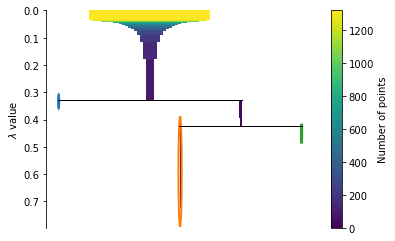

In [110]:
clusterer, df = hdbs(5, X)
hdbs_scatter("doc2vec-hdbscan", df, 20, 30)

### TSNE로 차원축소 시도

In [139]:
tsne = TSNE()
tsne_fit = tsne.fit_transform(X)
tsne_df = pd.DataFrame(tsne_fit, index=camp_df['camp'], columns=['x', 'y'])

['-1' '0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20'
 '21' '22' '23' '24' '25' '26' '27' '28' '29' '3' '4' '5' '6' '7' '8' '9']
아웃라이어 스코어:  [0.         0.02729041 0.         ... 0.22447811 0.         0.34105016]
Condensed tree plot


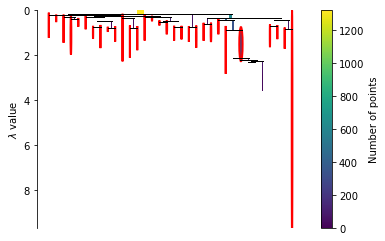

<AxesSubplot:ylabel='Density'>

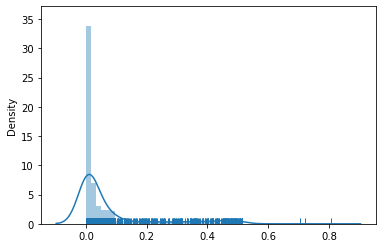

In [169]:
clusterer, df2 = hdbs(15, tsne_df)
hdbs_scatter("doc2vec-TSNE-hdbscan", df2)
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

['-1' '0' '1' '10' '11' '12' '2' '3' '4' '5' '6' '7' '8' '9']
아웃라이어 스코어:  [0.37193045 0.         0.         ... 0.         0.         0.11341145]
Condensed tree plot


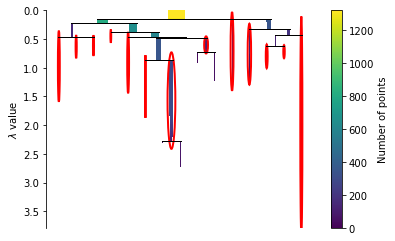

<AxesSubplot:ylabel='Density'>

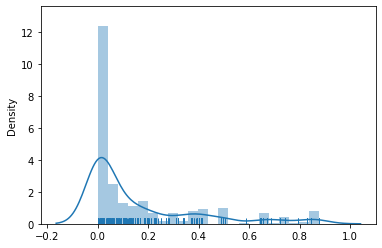

In [172]:
clusterer, df3 = hdbs(30, tsne_df)
hdbs_scatter("doc2vec-TSNE-hdbscan", df3)
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)